# X-Ray Classification using Convolutional Neural Networks (CNN)
**Author**: Eric Wehmueller
***

## Overview

This project is the fourth project for Flatiron School's bootcamp program in Data Science.  We are being placed into a hypothetical situation as a Data Scientist and hoping to provide value to our business for the scenario we are given.

## Business Problem

A concern in the years 2020 and 2021 has been "flattening the curve" for as to not overwhelm the health care system in the United States, and in other countries as well.  Using image analysis, classification, and convolutional neural networks (CNNs), the goal is to be able to correctly identify x-rays with a pneumonia diagnosis.  There may only be so many radiologists available at any given time- the hope is that something as complicated as xrays, to the untrained human eye, can be correctly read and analyzed by a model generated from a trained CNN.

## Setup and Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# tensorflow/keras libraries
import keras
import tensorflow as tf
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#setup GPU support for tensor
print("Num GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs:  0


Let's quickly take a look at our file structure, and set up file paths for future steps.

In [3]:
images_home = "../xray-classification/chest_xray_images/"
train_files = images_home+"train/"
test_files = images_home+"test/"
val_files = images_home+"val/"

In [4]:
print(os.listdir(train_files))

['NORMAL', 'PNEUMONIA']


In [5]:
train_norm = train_files+"NORMAL/"
train_sick = train_files+"PNEUMONIA/"

In [6]:
print(len(os.listdir(train_norm)))
print(len(os.listdir(train_sick)))

1042
3576


With ~1050 "normal" images and ~3600 pneumonia images, we may have a class imbalance to account for beyond our initial model.

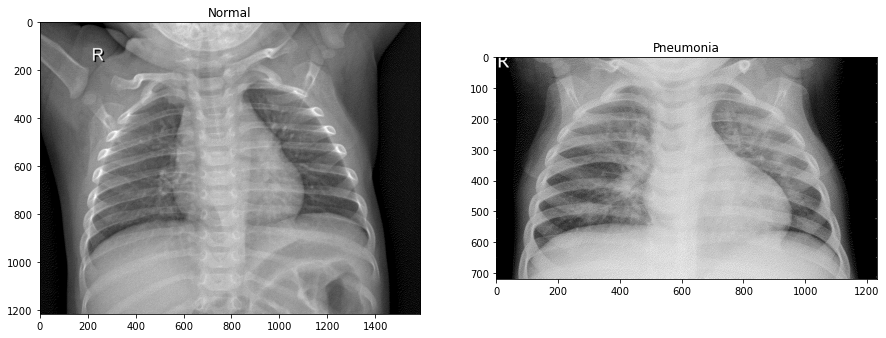

In [7]:
norm_pic_file = os.listdir(train_norm)[40]
sick_pic_file = os.listdir(train_sick)[40]

norm_pic_full_filname = train_norm + norm_pic_file
sick_pic_full_filname = train_sick + sick_pic_file

pic_norm = Image.open(norm_pic_full_filname).convert('1')
pic_sick = Image.open(sick_pic_full_filname).convert('1')

f = plt.figure(figsize=(15,15))
a_norm = f.add_subplot(1,2,1)
img_plot = plt.imshow(pic_norm)
a_norm.set_title("Normal")

a_sick = f.add_subplot(1,2,2)
img_plot = plt.imshow(pic_sick)
a_sick.set_title("Pneumonia");

As we can see, there's going to be a size imbalance between all the picture sizes. We will standardize this soon, for our model to succeed.

## Modeling

In [8]:
model = Sequential()

model.add(
    Conv2D(
        32, 
        (3, 3), 
        activation='relu', 
        input_shape=(64,64,3),
        padding='same')
    )
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation='sigmoid', units = 1)) #2 results, sick or not

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1843328   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 
               tf.keras.metrics.Precision(name='precision'), 
               tf.keras.metrics.Recall(name='recall')])

#binary_crossentroy due to the binary results

### Image Data Generation

This will be used to add shear and zoom to bolter our training data, adding more images for our model to train on and learn from.

In [10]:
#model.fit(train_images, train_labels, epochs=2, batch_size=64)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(train_files,
                                  target_size = (64,64),
                                  batch_size = 32,
                                  class_mode = 'binary');


test_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = test_datagen.flow_from_directory(val_files,
                                  target_size = (64,64),
                                  batch_size = 32,
                                  class_mode = 'binary');

test_generator = test_datagen.flow_from_directory(test_files,
                                  target_size = (64,64),
                                  batch_size = 32,
                                  class_mode = 'binary');

Found 4616 images belonging to 2 classes.
Found 616 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


To note, the distribution between train/val/test is roughly 70-15-15% which is acceptable.

In [11]:
cnn_model = model.fit(train_generator,
                         steps_per_epoch = 80,
                         epochs = 10,
                         validation_data = validation_generator,
                         validation_steps = 16)

Epoch 1/10
80/80 [==============================] - 33s 407ms/step - loss: 0.4470 - accuracy: 0.8043 - precision: 0.8190 - recall: 0.9544 - val_loss: 0.3041 - val_accuracy: 0.8594 - val_precision: 0.8195 - val_recall: 0.9116
Epoch 2/10
80/80 [==============================] - 31s 389ms/step - loss: 0.2308 - accuracy: 0.9089 - precision: 0.9277 - recall: 0.9573 - val_loss: 0.2254 - val_accuracy: 0.9004 - val_precision: 0.8581 - val_recall: 0.9612
Epoch 3/10
80/80 [==============================] - 31s 388ms/step - loss: 0.2070 - accuracy: 0.9191 - precision: 0.9381 - recall: 0.9585 - val_loss: 0.1591 - val_accuracy: 0.9512 - val_precision: 0.9587 - val_recall: 0.9393
Epoch 4/10
80/80 [==============================] - 31s 386ms/step - loss: 0.2022 - accuracy: 0.9207 - precision: 0.9397 - recall: 0.9607 - val_loss: 0.1645 - val_accuracy: 0.9297 - val_precision: 0.8978 - val_recall: 0.9685
Epoch 5/10
80/80 [==============================] - 31s 384ms/step - loss: 0.2050 - accuracy: 0.9219

In [12]:
test_acc = model.evaluate(test_generator, steps= 20)

20/20 [==============================] - 5s 253ms/step - loss: 0.7132 - accuracy: 0.7660 - precision: 0.7293 - recall: 0.9949


An evaluation on our test_gen indicates that we might be slightly overfitting, due to the reduced accuracy here.  However, we see a recall score of 99%, indicating we are doing well when correctly identifying actual pneumonia.

In [13]:
print('The testing accuracy is :',test_acc[1]*100, '%')

The testing accuracy is : 76.60256624221802 %


In [14]:
cnn_model.history

{'loss': [0.44701632857322693,
  0.23078864812850952,
  0.20704376697540283,
  0.2022145539522171,
  0.20499145984649658,
  0.18459567427635193,
  0.15905210375785828,
  0.1795593500137329,
  0.16606870293617249,
  0.15439562499523163],
 'accuracy': [0.8042968511581421,
  0.9089116454124451,
  0.919140636920929,
  0.920703113079071,
  0.9219242930412292,
  0.9261718988418579,
  0.9390624761581421,
  0.9290220737457275,
  0.937697172164917,
  0.9396687746047974],
 'precision': [0.8189806938171387,
  0.9276574850082397,
  0.9381494522094727,
  0.9396887421607971,
  0.9454545378684998,
  0.9501007795333862,
  0.9571428298950195,
  0.951392412185669,
  0.9530938267707825,
  0.9559999704360962],
 'recall': [0.9544290900230408,
  0.9573387503623962,
  0.9585439562797546,
  0.9607160687446594,
  0.9541284441947937,
  0.9544304013252258,
  0.9657057523727417,
  0.9572083353996277,
  0.9675785303115845,
  0.9671218991279602],
 'val_loss': [0.3041210472583771,
  0.22539827227592468,
  0.15905436

In [15]:
def plot_history(history, style=['ggplot', 'seaborn-talk']):
    # We can pass in a model history object or a dictionary.
    if not isinstance(history, dict): # We prefer this type of check over `if type() == ...`
        history = history.history

    metrics_lst = [m for m in history.keys() if not m.startswith('val')]
    N = len(metrics_lst)
    with plt.style.context(style):
        fig, ax_lst = plt.subplots(nrows=N, figsize=(8, 4*(N)))
        ax_lst = [ax_lst] if N == 1 else ax_lst.flatten() # Flatten ax_lst.
        for metric, ax in zip(metrics_lst, ax_lst):
            val_m = f'val_{metric}'
            ax.plot(history[metric], label=metric)
            ax.plot(history[val_m], label=val_m)
            ax.set(title=metric.title(), xlabel='Epoch', ylabel=metric.title())
            ax.legend()
        fig.tight_layout()
        plt.show()

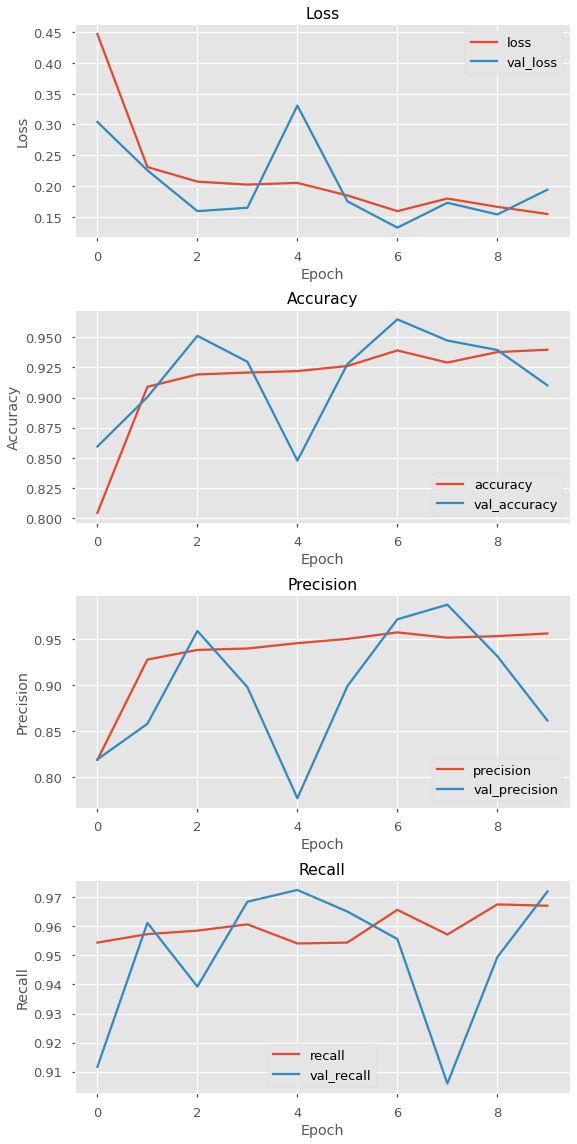

In [16]:
plot_history(cnn_model)

In [17]:
print(train_generator.class_indices)
test_images, test_labels = next(test_generator)
print(len(test_images), len(test_labels))

{'NORMAL': 0, 'PNEUMONIA': 1}
32 32


In [18]:
# y_hat = np.concatenate(model.predict(test_generator).round())
# print(len(y_hat))
# report = metrics.classification_report(test_labels, y_hat)
# print(report)

## Model Iteration

Here I'm going to add more convulutional layers, a dropout, and a swish activation on our dense layer.

In [19]:
model2 = Sequential()

model2.add(
    Conv2D(
        32, 
        (3, 3), 
        activation='relu', 
        input_shape=(64,64,3),
        padding='same')
    )
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))

model2.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model2.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model2.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(Dense(activation = 'swish', units = 128))
model2.add(keras.layers.Dropout(0.4))
model2.add(Dense(activation='sigmoid', units = 1)) #2 results, sick or not

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 96)        55392     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 96)        83040     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 96)         

In [20]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 
               tf.keras.metrics.Precision(name='precision'), 
               tf.keras.metrics.Recall(name='recall')])

In [21]:
cnn_model2 = model2.fit(train_generator,
                         steps_per_epoch = 50,
                         epochs = 15,
                         validation_data = validation_generator,
                         validation_steps = 16)

Epoch 1/15
50/50 [==============================] - 23s 454ms/step - loss: 0.5295 - accuracy: 0.7849 - precision: 0.7900 - recall: 0.9903 - val_loss: 0.7581 - val_accuracy: 0.4980 - val_precision: 0.4980 - val_recall: 1.0000
Epoch 2/15
50/50 [==============================] - 22s 446ms/step - loss: 0.3820 - accuracy: 0.8306 - precision: 0.8420 - recall: 0.9640 - val_loss: 0.4379 - val_accuracy: 0.7773 - val_precision: 0.7051 - val_recall: 0.9654
Epoch 3/15
50/50 [==============================] - 22s 445ms/step - loss: 0.2590 - accuracy: 0.8844 - precision: 0.9181 - recall: 0.9350 - val_loss: 0.2524 - val_accuracy: 0.8867 - val_precision: 0.9901 - val_recall: 0.7821
Epoch 4/15
50/50 [==============================] - 22s 436ms/step - loss: 0.2481 - accuracy: 0.8991 - precision: 0.9319 - recall: 0.9388 - val_loss: 0.2479 - val_accuracy: 0.8984 - val_precision: 0.8966 - val_recall: 0.9035
Epoch 5/15
50/50 [==============================] - 22s 445ms/step - loss: 0.2048 - accuracy: 0.9194

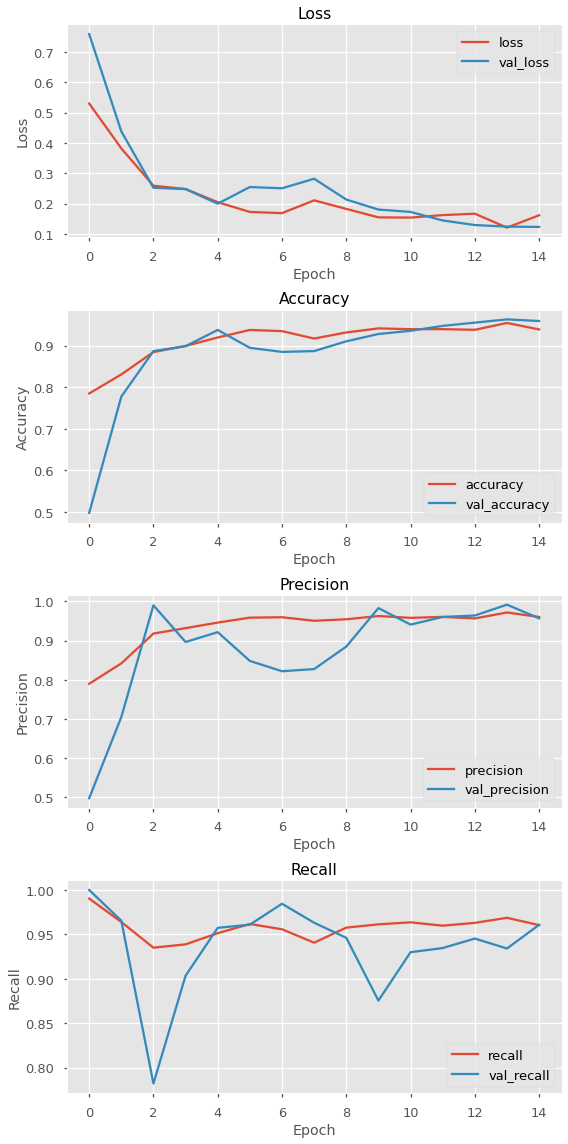

In [22]:
plot_history(cnn_model2)

In [23]:
test_acc2 = model2.evaluate(test_generator, steps= 20)

20/20 [==============================] - 5s 242ms/step - loss: 0.3034 - accuracy: 0.8942 - precision: 0.8699 - recall: 0.9769


In [24]:
confidence_array = model2.predict(test_generator)

In [25]:
print(confidence_array)
confidence_array[index]

[[0.03776717]
 [0.9963559 ]
 [0.99687934]
 [0.99823195]
 [0.99920905]
 [0.999786  ]
 [0.0206387 ]
 [0.8713292 ]
 [0.99966633]
 [0.9766138 ]
 [0.5329336 ]
 [0.12464675]
 [0.9018612 ]
 [0.990739  ]
 [0.01690188]
 [0.9992578 ]
 [0.0565334 ]
 [0.9703716 ]
 [0.04458356]
 [0.9727111 ]
 [0.98710907]
 [0.641751  ]
 [0.21706271]
 [0.48360577]
 [0.9852401 ]
 [0.23374793]
 [0.07403037]
 [0.9311868 ]
 [0.02733162]
 [0.5739472 ]
 [0.99818075]
 [0.99994284]
 [0.01350495]
 [0.5683852 ]
 [0.99969304]
 [0.9999162 ]
 [0.99984473]
 [0.99472713]
 [0.9222549 ]
 [0.42326105]
 [0.995179  ]
 [0.9975325 ]
 [0.9735364 ]
 [0.93495965]
 [0.9991344 ]
 [0.99844813]
 [0.95169103]
 [0.9998679 ]
 [0.9955952 ]
 [0.9936768 ]
 [0.94560295]
 [0.5510098 ]
 [0.92751986]
 [0.97087145]
 [0.99837685]
 [0.9875767 ]
 [0.239292  ]
 [0.04896179]
 [0.8496049 ]
 [0.9986311 ]
 [0.9998528 ]
 [0.99894345]
 [0.95305663]
 [0.2620734 ]
 [0.02762726]
 [0.97336686]
 [0.14732862]
 [0.9982884 ]
 [0.02177671]
 [0.99627805]
 [0.32446945]
 [0.70

NameError: name 'index' is not defined

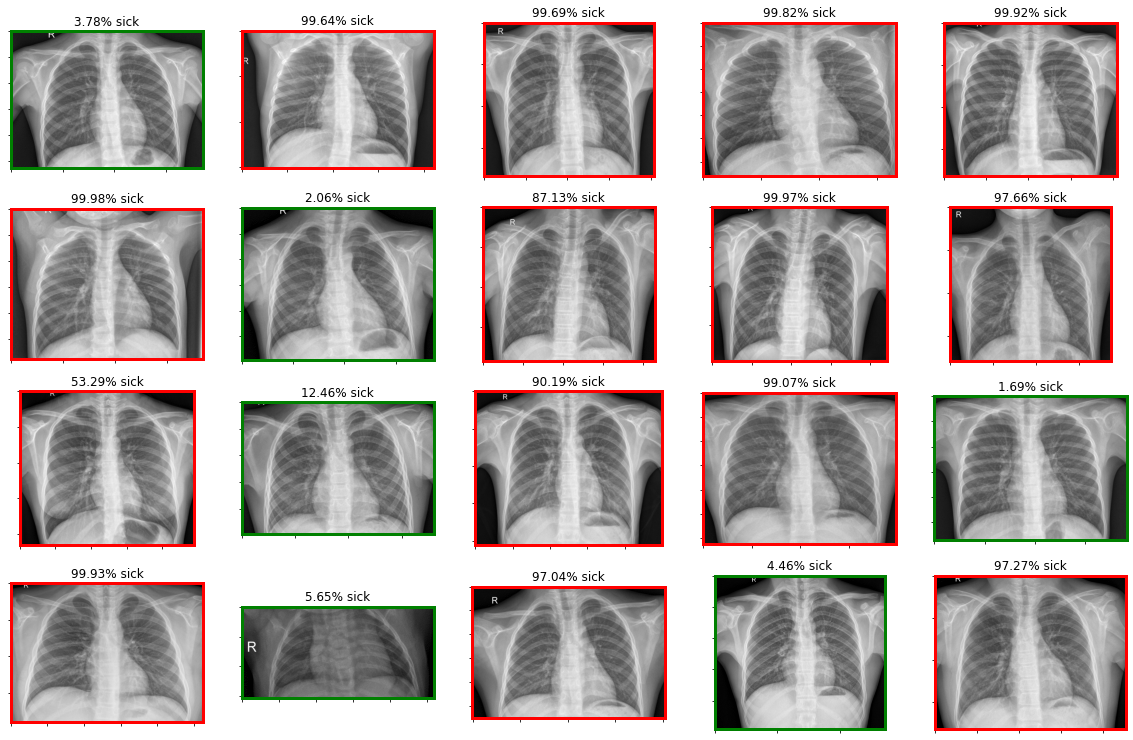

In [26]:

    #f = plt.figure(figsize=(15,15))
    #f, axarr = plt.subplots(3,5) 
    #a_norm = f.add_subplot(1,2,1)
    #img_plot = plt.imshow(img)
    #axarr.set_title("Normal")
    
    w = 10
    h = 10
    fig = plt.figure(figsize=(20, 13))
    columns = 5
    rows = 4

    # prep (x,y) for extra plotting
    xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
    ys = np.abs(np.sin(xs))           # absolute of sine

    # ax enables access to manipulate each of subplots
    ax = []

    #for i in range(columns*rows):
        #img = np.random.randint(10, size=(h,w))
    index = 0
    for filename in test_generator.filepaths[:20]:
        img = Image.open(filename).convert('1')
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, index+1))
        
        sick_pct = round(confidence_array[index][0]*100,2)
        string_title = ""
        if (sick_pct > 50):
            string_title = str(sick_pct)+"% sick"
            ax[-1].spines['bottom'].set_color('red')
            ax[-1].spines['top'].set_color('red') 
            ax[-1].spines['right'].set_color('red')
            ax[-1].spines['left'].set_color('red')
        else:
            string_title = str(sick_pct)+"% sick"
            ax[-1].spines['bottom'].set_color('green')
            ax[-1].spines['top'].set_color('green') 
            ax[-1].spines['right'].set_color('green')
            ax[-1].spines['left'].set_color('green')
        
        for axis in ['top','bottom','left','right']:
          ax[-1].spines[axis].set_linewidth(3)
        
        ax[-1].set_title(string_title)  # set title
        ax[-1].set_yticklabels([])
        ax[-1].set_xticklabels([])

        #ax.
        plt.imshow(img)
        index= index+1

    # do extra plots on selected axes/subplots
    # note: index starts with 0
    #ax[2].plot(xs, 3*ys)
    #ax[19].plot(ys**2, xs)

    plt.show()  # finally, render the plot


These graphs look like a solid improvement from our initial model. Our loss is continually decreasing towards the end of the epochs, and our precision reaches 94% by the 11th epoch. Recall doesn't seem to improve all that much but sits at a respectable 96% by the 15th epoch.  Overfitting may still be an issue, due to the lower values across the board for accuracy, precision, and recall on our model's evaluation on the test data set.

## Conclusion

Although our model has some overfitting issues due to the lower scores on the test data, we have a solid result. Unfortunately, our precision was not climbing very much at all; but it appears that our recall was tending upwards.

Our recall was consistently near 97% the end of the model's runtime.  This is probably the most relevant in the context of our project- this is the percentage of actual positives that were correctly classified.  In a situation like this, we want to find all patients who actually do have pneumonia so that they are placed into necessary care as soon as possible.  This makes it the standout statistic of the bunch in our outputs.

## Future Work

Good options moving forward would be to experiment with dense layers, adding more to have a more stable upwards curve while letting our model run for more epochs.  Additionally, this dataset did also have an issue with class distribution, as we had many more available xrays of patients WITH pneumonia than without. 
Accounting for this in a future model would be ideal.